# Predictive Modeling Challenge, using Gensim Bigrams

**Mark Wilber**

The challenge here is to build a classifier for 56 FDA food safety violation categories, which are very unbalanced (sizes spanning more than 3 orders of magnitude). There are two components/features:

* a boolean, `FDAISCRITICAL`, indicating whether the violation is 'critical' or not
* a description of the violation, `VIOCOMMENT`, which can range from 0 to 844 'words'

This notebook generates TF-IDF features after extracting unigrams and bigrams using gensim.models.phrases.Phrases() first to detect phrases using colocation counts, and then gensim.models.phrases.Phraser() to extract an efficient phrases model object. (Only those bigrams showing statistically significant counts are employed, greatly reducing the size of the 'vocabulary', along with training time.)

With these features logistic regression and random forest models are trained to compare f1 scores and training times.

<font color='darkgreen'>**As thise notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

## Preliminaries

**Next two lines are useful in the event of external code changes.**

In [1]:
%load_ext autoreload
%autoreload 2

### Python imports

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**`utility` contains generally helpful data science stuff, while `plotHelpers` includes plot functions specifically.**

In [3]:
import sys
sys.path.append('/home/wilber/work/Mlib/utility')
sys.path.append('/home/wilber/work/Mlib/plotHelpers')
import utility as util
import plotHelpers as ph

In [4]:
from time import time, asctime, gmtime
t0 = time()

# from platform import node
import os
from os.path import exists
# import shutil
# from glob import glob
from random import random
from collections import Counter, OrderedDict
import gc		# garbage collection module
import pprint
import pickle
import timeit

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
if 'sys' in sys.modules:
    print('sys', end="")
if 'utility' in sys.modules:
    print(', utility', end="")
if 'plotHelpers' in sys.modules:
    print(', plotHelpers', end="")
if 'platform' in sys.modules:
    print(', platform', end="")
if 'os' in sys.modules:
    print(', os', end="")
if 'os.path' in sys.modules:
    print(', os.path', end="")
if 'shutil' in sys.modules:
    print(', shutil', end="")
if 'glob' in sys.modules:
    print(', glob', end="")
if 'random' in sys.modules:
    print(', random', end="")
if 'collections' in sys.modules:
    print(', collections', end="")
if 'gc' in sys.modules:
    print(', gc', end="")
if 'pprint' in sys.modules:
    print(', pprint', end="")
if 'pickle' in sys.modules:
    print(', pickle', end="")
if 'timeit' in sys.modules:
    print(', timeit', end="")

from dateutil import __version__ as duVersion
from dateutil.parser import parse
import re
import numpy as np
import pandas as pd
import pyreadr

from scipy import __version__ as scVersion
import scipy.sparse as sp

from nltk import __version__ as nlVersion
from nltk.corpus import stopwords

import gensim
from gensim.models import TfidfModel

from sklearn import __version__ as skVersion
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB

from joblib import __version__ as jlVersion
from joblib import dump, load

import seaborn as sns
import colorcet as cc
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

print("\n")
if 'dateutil' in sys.modules:
    print("dateutil: {0}".format(duVersion), end="\t")
if 're' in sys.modules:
    print("re: {0}".format(re.__version__), end="\t")
if 'numpy' in sys.modules:
    print("numpy: {0}".format(np.__version__), end="\t")
if 'pandas' in sys.modules:
    print("pandas: {0}".format(pd.__version__), end="\t")
if 'pyreader' in sys.modules:
    print("pyreader: {0}".format(pyreader.__version__), end="\t")
if 'scipy' in sys.modules:
    print("scipy: {0}".format(scVersion), end="\t")
if 'nltk' in sys.modules:
    print("nltk: {0}".format(nlVersion), end="\t")
if 'gensim' in sys.modules:
    print("gensim: {0}".format(gensim.__version__), end="\t")
# if 'tensorflow' in sys.modules:
#     print("tensorflow: {0}".format(tfVersion), end="\t")
# if 'keras' in sys.modules:
#     print("keras: {0}".format(kerVersion), end="\t")
if 'sklearn' in sys.modules:
    print("sklearn: {0}".format(skVersion), end="\t")
if 'joblib' in sys.modules:
    print("joblib: {0}".format(jlVersion), end="\t")
if 'seaborn' in sys.modules:
    print("seaborn: {0}".format(sns.__version__), end="\t")
if 'colorcet' in sys.modules:
    print("colorcet: {0}".format(cc.__version__), end="\t")
if 'matplotlib' in sys.modules:
    print("matplotlib: {0}".format(mpVersion), end="\t")
# if '' in sys.modules:
#     print(": {0}".format(.__version__), end="\t")

%matplotlib inline

Python version:  (3, 7, 4, 'final', 0)
Un-versioned imports:

sys, utility, plotHelpers, platform, os, os.path, shutil, glob, random, collections, gc, pprint, pickle, timeit

dateutil: 2.8.0	re: 2.2.1	numpy: 1.16.4	pandas: 0.24.2	scipy: 1.3.0	nltk: 3.4.3	gensim: 3.7.3	sklearn: 0.21.2	joblib: 0.11	seaborn: 0.9.0	colorcet: 1.0.0	matplotlib: 3.1.0	

### Helper functions

#### Gensim-based helper functions

##### `sentenceToWords()`

* is a generator
* [`gensim.utils.simple_preprocess()`](https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess) converts a string into a list of lowercase tokens, ignoring tokens that are too short or too long

In [5]:
def sentenceToWords(sentences, maxLen=15):
    """
    • is a generator
    • gensim.utils.simple_preprocess() converts a string into a list of
      lowercase tokens, ignoring tokens that are too short min_len=2, (by
      default) or too long
    """
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), max_len=maxLen, deacc=True))		# deacc=True removes punctuations

##### `removeStopWords()`

* Accepts a list of lists, each list within the list containing tokens, representing a document, removes words in stopWords, and returns a flattened list of words.

 * Optionally accepts a regex, substitution pair (e.g., (r"['*]", "")) for making substitutions to alter words that are returned. The pair in the example would remove single quotes and asterisks. Useful when your corpus has idenfied idiosyncracies.

In [6]:
def removeStopwords(texts, stopWords, myRegex=None):
    """
    • Accepts a list of lists, each list within the list containing tokens,
      representing a document, removes words in stopWords, and returns a
      flattened list of words.

    • Optionally accepts a regex, substitution pair (e.g., (r"['*]", "")) for
      making substitutions to alter words that are returned. The pair in the
      example would remove single quotes and asterisks. Useful when your
      corpus has idenfied idiosyncracies.
    """

    if myRegex is None:
        return [[word for word in gensim.utils.simple_preprocess(str(doc)) \
                 if word not in stopWords] for doc in texts]
    else:
        return [[re.sub(myRegex[0], myRegex[1], word) \
                 for word in gensim.utils.simple_preprocess(str(doc)) \
                 if word not in stopWords] for doc in texts]

##### `bigrams()`

* uses [`gensim.models.phrases.Phrases()`](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phrases) first to detect phrases using colocation counts, and then [gensim.models.phrases.Phraser()](https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.Phraser) to extract a more-efficient phrases model object. The phrases object will take words in succession and decide which to return as joined words (e.g., "ice" followed by "cream" ⟶ "ice_cream"). There is much magic in this function ...

In [7]:
def bigrams(words, biMin=15, triMin=10):
    """
    • Uses gensim.models.phrases.Phrases() first to detect phrases using
      colocation counts, and then gensim.models.phrases.Phraser() to extract
      a more-efficient phrases model object. The phrases object will take
      words in succession and decide which to return as joined words (e.g.,
      "ice" followed by "cream" ⟶ "ice_cream").
    • There is much magic in this
      function ...
    """

    bigram = gensim.models.Phrases(words, min_count = biMin)
    bigramModel = gensim.models.phrases.Phraser(bigram)
    return bigramModel

##### `getTrainCorpus()`

* given `df` and name of column containing text, `textCol`, returns
  * `corpus`:	list of sparse arrays containing message word counts, in the form [(wordIds), (counts)] (as in [(0, 7133, 76, ...), (2, 3, 4, ...)])
  * `id2word`:	{dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words.
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams

In [8]:
@ph.timeUsage
def getTrainCorpus(df, textCol, stopWords, myRegex=None):
    """
    • given df and name of column containing text, textCol, stopWords, returns:
      • corpus: list of sparse arrays containing message word counts, in the
        form [(wordIds), (counts)] (as in [(0, 7133, 76, ...), (2, 3, 4, ...)])
      • id2word: {dict of (int, str), gensim.corpora.dictionary.Dictionary})
        – Mapping from word IDs to words.
      • bigram: list of lists of tokens as unigrams or underscored_bigrams
    • See sentenceToWords() for the use of and myRegex keyword.
    """

    words = list(sentenceToWords(df[textCol]))
    words = removeStopwords(words, stopWords, myRegex=myRegex)
    bigramModel = bigrams(words)
    bigram = [bigramModel[word] for word in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

##### `getTestCorpus()`

* As we will already have id2word from getTrainCorpus(), it's only necessary to get the corpus and bigrams for the test data.
* given `df` and name of column containing text, `textCol`, returns
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams
  * This is the test version of `getCorpus()`, in that `id2word` has already been found.

In [9]:
@ph.timeUsage
def getTestCorpus(df, textCol, id2word, stopWords, myRegex=None):
    """
    As we will already have id2word from getTrainCorpus(), it's only necessary
    to get the corpus and bigrams for the test data.
    """

    words = list(sentenceToWords(df[textCol]))
    words = removeStopwords(words, stopWords, myRegex=myRegex)
    bigramModel = bigrams(words)
    bigram = [bigramModel[word] for word in words]
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, bigram

## Handle the data

### Read data into a DataFrame

* Have a very quick look at DataFrame characteristics

In [10]:
fname = "SelectedInspectionReportData.rds"

result = pyreadr.read_r(fname)
df = result[None]
df.fda_q_fixed = df.fda_q_fixed.astype('int')
df.FDAISCRITICAL = df.FDAISCRITICAL.astype('int')
df.shape

(1307986, 12)

In [11]:
df.head(6).T
df.tail(6).T

,0,1,2,3,4,5
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,,,,,,
PICKLIST,6-301.11,4-601.11(A),4-204.112,3-302.12,6-404.11,4-501.11
VIOCOMMENT,Soap and/or paper towels are not provided for ...,Food contact surfaces and utensils are not cle...,An accurate product temperature-measuring devi...,Bulk containers are not properly labeled. V/C,Food products that are held by the food establ...,Non-food contact equipment is not maintained i...
FDAQUESTION,8,14,34,35,37,45
VIOISCOS,1,1,1,1,1,1
VIOLATIONID,,,,,,
FDAISCRITICAL,0,0,1,1,1,1
VIOISRPT,,,,,,
VIOCODE,,,,,,


,1307980,1307981,1307982,1307983,1307984,1307985
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,"January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00"
PICKLIST,6-501.11,6-501.12(1),3-305.11,4-903.11 (42),4-903.11 (42),4-501.11
VIOCOMMENT,"Floors, walls, and ceilings not in good repair","Floors, walls, and ceilings not clean",Food was not separated and protected from cont...,Equipment and utensils not properly installed ...,Equipment and utensils not properly stored or ...,Utensils and equipment unapproved or not in go...
FDAQUESTION,53,53,37,42,42,45
VIOISCOS,0,0,0,0,0,0
VIOLATIONID,100960663,100960664,100960679,100960681,100960682,100960680
FDAISCRITICAL,0,0,0,0,0,0
VIOISRPT,0,0,0,0,0,0
VIOCODE,53,53,37,45,42,45


#### Basic summary

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 12 columns):
HZLVIOLATIONID      1307986 non-null object
VIOCORRECTBYDATE    1307986 non-null object
PICKLIST            1307986 non-null object
VIOCOMMENT          1307986 non-null object
FDAQUESTION         1307986 non-null object
VIOISCOS            1307986 non-null object
VIOLATIONID         1307986 non-null object
FDAISCRITICAL       1307986 non-null int64
VIOISRPT            1307986 non-null object
VIOCODE             1307986 non-null object
JURISDICTIONID      1307986 non-null float64
fda_q_fixed         1307986 non-null int64
dtypes: float64(1), int64(2), object(9)
memory usage: 119.7+ MB


In [13]:
df.describe()

,FDAISCRITICAL,JURISDICTIONID,fda_q_fixed
count,1.307986e+06,1.307986e+06,1.307986e+06
mean,3.141234e-01,2.818328e+02,3.773050e+01
std,4.641660e-01,2.400974e+02,1.619210e+01
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,0.000000e+00,1.360000e+02,2.200000e+01
50%,0.000000e+00,1.530000e+02,4.400000e+01
75%,1.000000e+00,3.880000e+02,5.000000e+01
max,1.000000e+00,9.730000e+02,5.600000e+01


#### Remove columns from DataFrame which we won't need

In [14]:
df = df[['fda_q_fixed', 'VIOCOMMENT', 'FDAISCRITICAL']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 3 columns):
fda_q_fixed      1307986 non-null int64
VIOCOMMENT       1307986 non-null object
FDAISCRITICAL    1307986 non-null int64
dtypes: int64(2), object(1)
memory usage: 29.9+ MB


### Exploratory analysis

#### Classes and relative balance

* The stuff using patches is for placing counts above each rectangle in the bar plot

In [15]:
FDAcodes = list(set(df['fda_q_fixed'].values))
print(FDAcodes)
classCts = pd.DataFrame(df['fda_q_fixed'].value_counts())
with pd.option_context("display.max_columns", 60):
    display(classCts.T)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


,55,49,47,16,10,22,51,56,39,44,41,38,54,48,43,28,40,45,36,8,21,15,6,24,53,37,23,2,33,1,50,20,13,9,52,35,3,29,18,25,5,11,19,14,4,42,31,46,17,12,32,7,26,30,27,34
fda_q_fixed,171202,122314,121997,103357,69288,57210,56230,51223,46145,45333,42241,37133,30016,27602,26638,24426,24016,22845,21351,20585,18874,18156,15947,15218,13428,13294,12675,12630,11494,7844,7019,5747,5495,4213,3738,3513,2774,1910,1859,1770,1602,1550,1351,933,883,849,492,464,348,225,216,166,63,34,33,27


Δt:  0.82s.


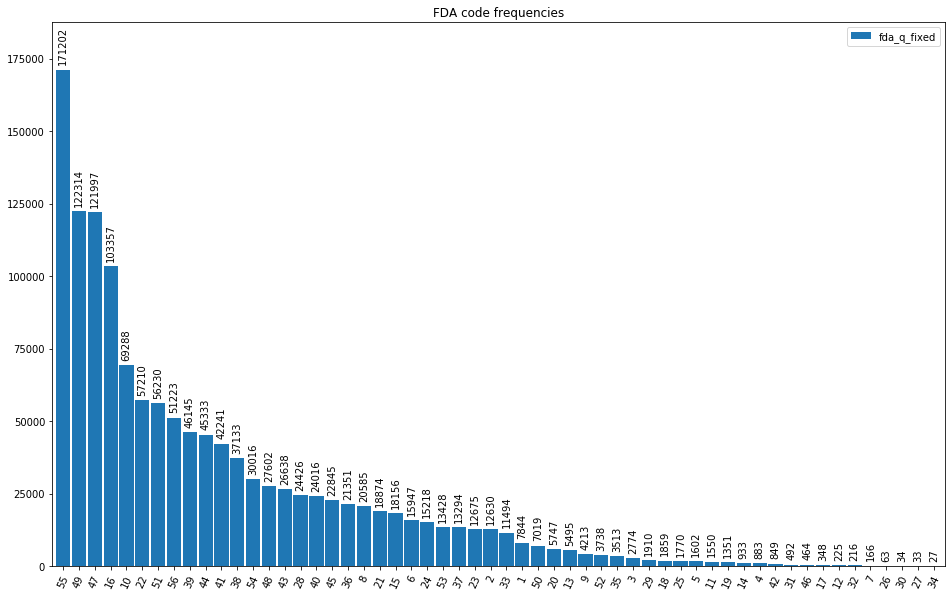

In [16]:
ph.plotValueCounts(df, 'fda_q_fixed', titleText='FDA code frequencies', saveAs='svg', ylim=[0.0, 187500.0])

***The class sizes span nearly 4 orders of magnitude!***

#### Word frequencies

In [17]:
t0 = time()
df['commentsWords'] = df['VIOCOMMENT'].apply(lambda s: s.split())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  6.9s.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
comments = list(df['commentsWords'])

##### Distribution of comment lengths

* Add length of each comment to DataFrame as `wordFreq` column

In [19]:
wordLens = [len(wordList) for wordList in comments]
df['wordFreq'] = wordLens
wordFreqMode = df['wordFreq'].mode().values[0]

wordCtSorted = sorted(wordLens)
print("smallest word counts:\n", wordCtSorted[:100])
print("largest word counts:\n", wordCtSorted[-101:-1])

smallest word counts:
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
largest word counts:
 [434, 434, 434, 440, 440, 440, 440, 440, 440, 441, 441, 442, 453, 454, 454, 458, 464, 464, 464, 464, 464, 464, 466, 466, 474, 474, 476, 476, 476, 480, 480, 481, 481, 481, 488, 498, 498, 498, 498, 503, 506, 506, 511, 511, 511, 533, 533, 534, 534, 535, 535, 536, 536, 536, 538, 538, 539, 542, 542, 542, 547, 552, 552, 553, 553, 564, 577, 577, 580, 580, 580, 580, 580, 580, 594, 594, 615, 615, 615, 619, 619, 619, 628, 628, 644, 644, 644, 649, 649, 670, 670, 670, 671, 671, 782, 782, 787, 787, 806, 806]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**Detailed histogram**

Found  844 bins in data array.
Saving as  WordCountsHistWordCountsMax844Mode8.svg .
Δt:  3.10s.


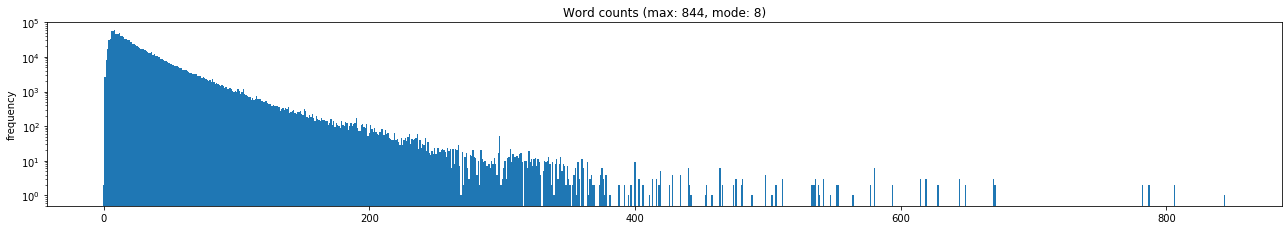

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))

ph.detailedHistogram(wordLens, ylabel='frequency', volubility=2,
                     titleText=f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})",
                     figName="WordCountsHist", ax=ax, ylim = [0.5, 100000.0], ylog=True, saveAs='svg')

**Make space**

In [21]:
del wordLens
del wordCtSorted
del df['commentsWords']

##### What FDA codes correspond to those comments having `wordFreq== 0`?

In [22]:
df[df['wordFreq']==0]
print("\n", df.shape)

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
610833,49,,1,0
610835,49,,1,0



 (1307986, 4)


**Can safely remove a couple of records from the 2nd-most populated category**

* Originally there were 1307986 records in `df`, out of which 122314 were in Class 49

In [23]:
df = df[df['wordFreq']!=0]
df.shape

(1307984, 4)

##### `wordFreq` percentiles

* These show that would get 99% coverage of the comments without truncation if were to use, say, 140-element LSTMs

In [24]:
df.describe(percentiles=[0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

,fda_q_fixed,FDAISCRITICAL,wordFreq
count,1.307984e+06,1.307984e+06,1.307984e+06
mean,3.773048e+01,3.141223e-01,2.734516e+01
std,1.619211e+01,4.641656e-01,2.859241e+01
min,1.000000e+00,0.000000e+00,1.000000e+00
1%,2.000000e+00,0.000000e+00,3.000000e+00
5%,9.000000e+00,0.000000e+00,5.000000e+00
15%,1.600000e+01,0.000000e+00,7.000000e+00
25%,2.200000e+01,0.000000e+00,1.000000e+01
50%,4.400000e+01,0.000000e+00,1.800000e+01
75%,5.000000e+01,1.000000e+00,3.500000e+01


#### Most-common words

In [25]:
allWords = [word for wordList in comments for word in wordList]		# Flatten list of lists of words
print(len(comments), len(allWords))

print(comments[:5], "\n", allWords[:25])

1307986 35767027
[['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C'], ['Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to', 'sight', 'and', 'touch.', 'V/C'], ['An', 'accurate', 'product', 'temperature-measuring', 'device', 'is', 'not', 'provided.', 'V/C'], ['Bulk', 'containers', 'are', 'not', 'properly', 'labeled.', 'V/C'], ['Food', 'products', 'that', 'are', 'held', 'by', 'the', 'food', 'establishment', 'for', 'credit,', 'redemption', 'or', 'return', 'to', 'the', 'distributor', 'are', 'not', 'segregated', 'and', 'held', 'in', 'designated', 'areas', 'that', 'are', 'separated', 'from', 'food,', 'equipment,', 'utensils,', 'linens,', 'and', 'single', 'use', 'utensils/articles.', 'V/C']] 
 ['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C', 'Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to

In [26]:
t0 = time()
wordCtr = Counter(allWords)
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  5.7s.


##### Most common words, after removing stop words

*Result looks very plausible*

In [27]:
stopWords = text.ENGLISH_STOP_WORDS.union(['-'])

wcStops = [k for k in wordCtr if k.lower() in stopWords]
for k in wcStops:
    del wordCtr[k]
wordCtr.most_common(40)

[('food', 416195),
 ('Observed', 199727),
 ('stored', 190927),
 ('Basic', 172943),
 ('shall', 164416),
 ('sink', 135404),
 ('clean', 134875),
 ('cooler', 127169),
 ('equipment', 116502),
 ('surfaces', 101198),
 ('ice', 98110),
 ('properly', 92639),
 ('floor', 89994),
 ('area', 89722),
 ('water', 89455),
 ('Food', 88648),
 ('contact', 87364),
 ('used', 85530),
 ('hand', 85441),
 ('temperature', 83565),
 ('**Warning**', 83220),
 ('prep', 82074),
 ('time', 77755),
 ('observed', 77699),
 ('storage', 72918),
 ('utensils', 66834),
 ('employee', 65779),
 ('On-Site**', 65728),
 ('**Corrected', 65545),
 ('machine', 65157),
 ('use', 64437),
 ('area.', 62940),
 ('Clean', 62534),
 ('cold', 62019),
 ('inspection', 61344),
 ('Correction:', 60798),
 ('holding', 60728),
 ('good', 60532),
 ('line', 60306),
 ('items', 58171)]

#### Clean up

In [28]:
del allWords
del wordCtr

#### `fda_q_fixed` vs. `FDAISCRITICAL`

What is the relationship between the critical violation boolean and the FDA code?

In [29]:
dfCrit = df.groupby(['fda_q_fixed', 'FDAISCRITICAL']).count()
del dfCrit['VIOCOMMENT']
del dfCrit['wordFreq']
dfCrit.head(20)

dfCrit.reset_index(inplace=True)
dfCrit.head(20)

Empty DataFrame
Columns: []
Index: [(1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1), (6, 0), (6, 1), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0)]

,fda_q_fixed,FDAISCRITICAL
0,1,0
1,1,1
2,2,0
3,2,1
4,3,0
5,3,1
6,4,0
7,4,1
8,5,0
9,5,1


Text(0.5, 0.98, 'Critical violations vs FDA code')

(0.5, 56.5)

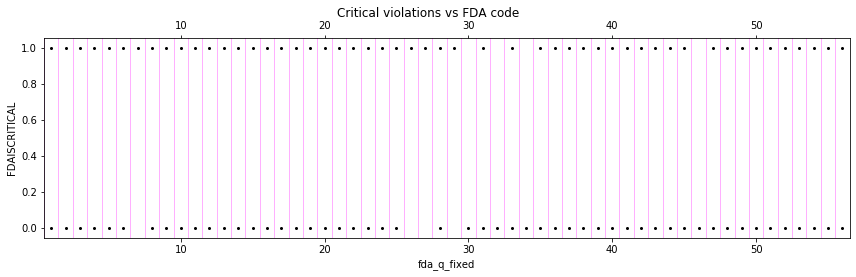

In [30]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfCrit.plot.scatter('fda_q_fixed', 'FDAISCRITICAL', s=4, c='black', ax=ax)
for xv in np.linspace(0.5, 56.5, 57):
    plt.axvline(x=xv, c="#FFB0FF", linewidth=1)
plt.suptitle('Critical violations vs FDA code')
ax.set_xlim([0.5, 56.5])
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('CriticalViolationVsFDAcode.svg')

**The critical violations plot shows that `FDAISCRITICAL` should be predictive (and certainly should be included in the model):**

* classes 30, 32, 34 &amp; 46 *never* have critical violations
* classes 7, 26, 27 &amp; 29 *only* have critical violations

## Pre-process data

* Here we use TF-IDF features to represent the comment text.

### Split DataFrame by classes

`splitDataFrameByClasses()` will create two new DataFrames, dfTr, dfTe, according to the desired splits.

* Splitting is done on a per-class basis, so that random selection will not, by chance, yield huge imbalances in train-test splits of tiny classes

In [32]:
classColumn = 'fda_q_fixed'
dfTrain, dfTest = util.splitDataFrameByClasses(df, classColumn,
                                               testFrac=0.50, myRandomState=0)
dfTrain.shape, dfTest.shape
dfTrain.head()
dfTest.head()

df.shape: (1307984, 4)
dfTrain.shape: (653979, 4)	dfTest.shape: (654005, 4)
Δt:  2.80s.


((653979, 4), (654005, 4))

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,43,Ice scoop,0,2
1,16,Intermediate - Accumulation of black/green mol...,1,29
2,41,Basic - Wiping cloth quaternary ammonium compo...,0,25
3,9,3717-1-03.2(A)(2) - Critical - Preventing cont...,1,70
4,22,High Priority - Potentially hazardous (time/te...,1,48


,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,50,Hot and cold water available,0,5
1,22,High Priority - Potentially hazardous (time/te...,1,43
2,51,"Plumbing and sinks not properly sized, install...",0,14
3,22,3-501.16 (A)(2) and (B) Potentially Hazardous ...,1,77
4,49,Accumulation of food debris in condiment/bins ...,0,41


**As intended, `splitDataFrameByClasses()` created a new train DataFrame with 1307984/2 = 653992 rows, and a test DataFrame with 653979 ~ 1307984 / 2 = 653992 rows.**

*The test DataFrame is not exactly an even split of the original, since the splitting is done by class, with some classes having odd counts, and then unioned.*

### Extract text, clean up, remove stop words

#### Fetch stop words from NLTK

Note: if there is reason to add to standard stop words, use .extend method:
```python3
stopWords.extend(['word0', 'word1', 'word2'])
```

In [33]:
stopWords = stopwords.words('english')

#### Run `getTrainCorpus()` to get bag of word features, dicts (~4m, 30s)

* given `df` and name of column containing text, `textCol`, returns
  * `corpus`:	list of sparse arrays containing message word counts, in the form [(wordIds), (counts)] (as in [(0, 7133, 76, ...), (2, 3, 4, ...)])
  * `id2word`:	{dict of (int, str), gensim.corpora.dictionary.Dictionary}) – Mapping from word IDs to words.
  * `bigram`:	list of lists of tokens as unigrams or underscored_bigrams, such as [['food', 'total_idiot', 'nurd'], ['yank', 'sift', 'clean'], ... ]

In [34]:
print(asctime(gmtime()))
trainCorpus, ID2word, trainBigram = getTrainCorpus(dfTrain, 'VIOCOMMENT', stopWords, myRegex=(r"['*]", ""))

Δt: 4m, 31.4s.


##### Introspection &mdash; What have we wrought?

In [35]:
type(trainCorpus), type(ID2word), type(trainBigram)

(list, gensim.corpora.dictionary.Dictionary, list)

In [36]:
for l in trainCorpus[:5]:
    print(l)

[(0, 1), (1, 1)]
[(0, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
[(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]
[(0, 2), (1, 1), (29, 1), (30, 1), (31, 2), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)]
[(11, 1), (13, 1), (15, 1), (41, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)]


In [37]:
for l in trainBigram[:5]:
    print(l)

['ice', 'scoop']
['intermediate', 'accumulation', 'black_green', 'mold_like', 'substance', 'interior', 'ice', 'machine', 'ice', 'machine', 'back', 'kitchen', 'ice', 'bin', 'waitress_station', 'repeat', 'violation', 'warning']
['basic', 'wiping_cloth', 'quaternary_ammonium', 'compound_sanitizing', 'solution', 'proper', 'minimum_strength', 'concentration', 'ppm', 'manager', 'remade', 'ppm', 'corrected', 'site']
['critical', 'preventing_contamination', 'hands', 'bare', 'hand', 'contact', 'observed', 'food', 'employee', 'touching', 'ready_eat', 'food', 'bare_hands', 'employee', 'placed', 'finger', 'french_fries', 'bagging', 'repeatedly', 'scooped', 'ice', 'cup', 'ice', 'scoop', 'prevent', 'contamination', 'except', 'washing', 'raw', 'fruits_vegetables', 'food', 'employees', 'may', 'contact', 'exposed', 'ready_eat', 'food', 'bare_hands', 'shall', 'use', 'suitable', 'utensils']
['high_priority', 'potentially_hazardous', 'time', 'temperature', 'control_safety', 'food', 'cold', 'held_greater',

In [38]:
print(len(ID2word))
keys = ID2word.keys()
for key in keys[:15]:
    print(key, ID2word[key])

32872
0 ice
1 scoop
2 accumulation
3 back
4 bin
5 black_green
6 interior
7 intermediate
8 kitchen
9 machine
10 mold_like
11 repeat
12 substance
13 violation
14 waitress_station


### It's TF-IDF time

#### Train `TfidfModel`

* This means feed the 'model' a train corpus, and it will compute both document frequencies and term frequencies.

In [39]:
tfidf = TfidfModel(trainCorpus, id2word=ID2word)
type(tfidf)

gensim.models.tfidfmodel.TfidfModel

#### Get TF-IDF features for `trainCorpus`

In [40]:
trainCorpusTFIDF = tfidf[trainCorpus]
type(trainCorpusTFIDF)

gensim.interfaces.TransformedCorpus

**Note that when fed corpus lists tfidf returns `ID2word` labels and TF-IDF values for the text, but without repeats and in dict label order, rather than the text word order.**

In [41]:
i = 0
for i, doc in enumerate(trainCorpusTFIDF):
    if i > 2:
        break
    print(i, ': ', doc)
    i += 1

0 :  [(0, 0.4975413266704279), (1, 0.8674402735952664)]
1 :  [(0, 0.4383780860059818), (2, 0.17656208329887407), (3, 0.18780229113836874), (4, 0.26217462550477144), (5, 0.30836834970148413), (6, 0.2266391199324125), (7, 0.18814754244733833), (8, 0.17224527631099992), (9, 0.3015308414564577), (10, 0.2513492980251441), (11, 0.16498869145217707), (12, 0.25466260066181257), (13, 0.1388030299909784), (14, 0.41398232074374813), (15, 0.1558900812770243)]
2 :  [(16, 0.1152961569036865), (17, 0.3849331937358369), (18, 0.24422507523966158), (19, 0.11796627541831674), (20, 0.1789722428121306), (21, 0.3143993653191235), (22, 0.4659534670787774), (23, 0.16927060065061444), (24, 0.3139834918395945), (25, 0.38998965792825985), (26, 0.13917968434253783), (27, 0.2437112267050002), (28, 0.24266107170192203)]


#### Convert gensim train TF-IDF vectors into a scipy.sparse matrix

##### Get `Xtrain`

* initialize a linked-list sparse matrix of shape `(len(trainCorpusTFIDF), len(ID2word))` (~3 seconds)
* iterate through all elements of list of lists making up `trainCorpusTFIDF` and assign weights to corresponding elements of `Xtrain` (~2 minutes)
* convert to sp.csr_matrix (~4 seconds)

In [42]:
t0 = time()
Xtr = sp.lil_matrix((len(trainCorpusTFIDF), len(ID2word)), dtype=float)
Xtr
Δt = time() - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

<653979x32872 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [43]:
t0 = time()
for i, doc in enumerate(trainCorpusTFIDF):
    for tfidfWeight in doc:
        Xtr[i, tfidfWeight[0]] = tfidfWeight[1]
Δt = time() - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt: 59.8s.


In [44]:
Xtr = sp.csr_matrix(Xtr)
Xtr.shape

(653979, 32872)

##### Combine train TF-IDF with booleans

* stack `FDAISCRITICAL` column from dfTrain to create input matrix for training classifiers (< 1s)

In [45]:
Xtrain = sp.hstack([Xtr, sp.csr_matrix(dfTrain[['FDAISCRITICAL']])], 'csr')
print(np.shape(Xtrain), type(Xtrain))

(653979, 32873) <class 'scipy.sparse.csr.csr_matrix'>
Δt:  0.5s.


#### Get yTrain

In [46]:
yTrain = dfTrain['fda_q_fixed'].values
len(yTrain)

653979

#### Run `getTestCorpus()` to get bag of words features for the test set (~4 minutes)

In [47]:
t0 = time()
testCorpus, testBigram = getTestCorpus(dfTest, 'VIOCOMMENT', ID2word, stopWords, myRegex=(r"['*]", ""))
Δt = time() - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt: 4m, 13.4s.
Δt: 13.4s.


In [48]:
print(len(trainCorpusTFIDF))

653979


In [49]:
for l in testCorpus[:5]:
    print(l)

[(62, 1), (96, 1), (624, 1), (1200, 1)]
[(0, 3), (11, 1), (13, 1), (15, 1), (41, 2), (62, 1), (64, 1), (68, 1), (71, 1), (72, 1), (77, 1), (81, 1), (82, 1), (150, 1), (264, 1), (578, 1), (670, 1), (1306, 2), (4906, 1), (8157, 1), (19688, 1)]
[(158, 1), (185, 2), (195, 1), (548, 1), (567, 1), (1049, 1), (2095, 1), (2096, 1)]
[(41, 2), (51, 1), (62, 1), (64, 1), (65, 1), (73, 1), (74, 1), (75, 1), (77, 1), (81, 2), (82, 1), (84, 1), (96, 1), (97, 1), (126, 1), (136, 1), (139, 1), (155, 1), (159, 1), (160, 1), (185, 1), (202, 1), (237, 1), (255, 1), (291, 3), (305, 1), (484, 1), (499, 1), (1032, 1), (1343, 1), (1386, 1), (2520, 1), (2805, 1), (3785, 1), (20307, 1)]
[(0, 1), (2, 1), (35, 1), (41, 1), (95, 1), (96, 1), (139, 1), (158, 1), (181, 1), (191, 1), (198, 1), (215, 1), (244, 1), (262, 1), (332, 1), (345, 1), (490, 1), (538, 1), (962, 1), (1334, 1), (2401, 1), (3076, 1), (3412, 1), (6260, 1), (8071, 1)]


#### Get TF-IDF features for `testCorpus`

In [50]:
type(tfidf)

gensim.models.tfidfmodel.TfidfModel

In [51]:
testCorpusTFIDF = tfidf[testCorpus]
type(testCorpusTFIDF)

gensim.interfaces.TransformedCorpus

#### Convert gensim test TF-IDF vectors into a scipy.sparse matrix

##### Get `Xtest`

In [52]:
Xte = sp.lil_matrix((len(testCorpusTFIDF), len(ID2word)), dtype=float)
Xte

<654005x32872 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in LInked List format>

In [53]:
t0 = time()
for i, doc in enumerate(testCorpusTFIDF):
    for tfidfWeight in doc:
        Xte[i, tfidfWeight[0]] = tfidfWeight[1]
Δt = time() - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt: 57.0s.


In [54]:
Xte = sp.csr_matrix(Xte)
Xte.shape

(654005, 32872)

##### Combine test TF-IDF with booleans

* stack `FDAISCRITICAL` column from dfTest to create input matrix for training classifiers

In [55]:
Xtest = sp.hstack([Xte, sp.csr_matrix(dfTest[['FDAISCRITICAL']])], 'csr')
print(np.shape(Xtest), type(Xtest))

(654005, 32873) <class 'scipy.sparse.csr.csr_matrix'>


#### Get yTest

In [56]:
yTest = dfTest['fda_q_fixed'].values
len(yTest)

654005

#### Sanity check: show features most correlated with classes

* Figure out which of 329k features are most correlated with each of the FDA codes

In [57]:
# t0 = time()
# N = 5

# FDAcodes = sorted(list(set(df.fda_q_fixed)))

# for FDAcode in FDAcodes:
#     Xχ2 = chi2(Xtr, yTrain==FDAcode)
#     indices = np.argsort(Xχ2[0])
#     featureNames = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in featureNames if len(v.split(' ')) == 1]
#     bigrams = [v for v in featureNames if len(v.split(' ')) == 2]
#     print(f"\nFCA code {FDAcode:02d}:")
#     print("Most correlated unigrams::\t{{{}".format('}  {'.join(unigrams[-N:])), end='}')
#     print("\nMost correlated bigrams::\t{{{}".format('}  {'.join(bigrams[-N:])), end='}')
# t1 = time()
# Δt = t1 - t0
# print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

In [58]:
del Xtr
del Xte

### Do some garbage collection before building models

In [59]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 120
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


## Models

### Logistic Regression

#### TF-IDF with `FDAISCRITICAL`

* Run defaults for now, except `class_weight='balanced'`
* `n_jobs=7` means use 8 processors (as it is set to $n_{\mathrm{threads}} - 1$)
* For np.shape(Xtrp) = (560000, 196227), fit takes ~15 min.

In [60]:
np.shape(Xtrain), np.shape(yTrain), np.shape(Xtest), np.shape(yTest)

((653979, 32873), (653979,), (654005, 32873), (654005,))

In [61]:
print(asctime(gmtime()))
LR1name = 'LogisticRegressor1.joblib'

if os.path.isfile(LR1name):
    LR = load(LR1name)
    t1 = time()
else:
    CV = 5
    LR = LogisticRegression(random_state=0, n_jobs=7,
                            solver='newton-cg', class_weight='balanced')
    t0 = time()
    LR.fit(Xtrain, yTrain)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = LR.predict(Xtest)
t2 = time()
Δt12 = t2 - t1
print("Δt12: {0} m, {1:4.1f} s.".format(int(Δt12//60), Δt12 % 60.0))

Tue Aug 20 06:09:23 2019


/home/wilber/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=7, penalty='l2',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Δt01: 14 m, 17.8 s.
Δt12: 0 m,  1.0 s.


In [62]:
print(yTest[:20])
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 49 15 28 39 51 16 39 55 55 16 48 21 38 33 38 49]


**Save model to disk**

In [63]:
if not os.path.isfile(LR1name):
    dump(LR, LR1name)

['LogisticRegressor1.joblib']

#### Overall accuracy, precision, recall

In [64]:
confusionMat = confusion_matrix(yTest, yPred)
print(confusionMat)

[[ 2695   468   274 ...     0     0     2]
 [  410  5784    49 ...     0     0     0]
 [  123    58  1115 ...     0     0     1]
 ...
 [    0     0     0 ... 13585   327    73]
 [    7     6     3 ...   584 66887  2716]
 [    3     1     0 ...    74  1356 20653]]


In [65]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.836, <precision>: 0.723, <recall>: 0.766


##### Recall, precision by class

In [66]:
print(metrics.classification_report(yTest, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.77      0.69      0.73      3922
           2       0.89      0.92      0.90      6315
           3       0.69      0.80      0.74      1387
           4       0.53      0.34      0.42       442
           5       0.88      0.93      0.90       801
           6       0.91      0.92      0.91      7974
           7       0.51      0.80      0.62        83
           8       0.86      0.87      0.87     10293
           9       0.82      0.87      0.84      2107
          10       0.96      0.97      0.96     34644
          11       0.47      0.45      0.46       775
          12       0.59      0.44      0.51       113
          13       0.68      0.76      0.72      2748
          14       0.85      0.84      0.85       467
          15       0.84      0.84      0.84      9078
          16       0.95      0.95      0.95     51679
          17       0.63      0.45      0.53       174
          18       0.75    

In [67]:
classCts = dfTest['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.863		0.781	0.820		85601
49	0.776		0.775	0.775		61156
47	0.806		0.719	0.760		60999
16	0.952		0.950	0.951		51679
10	0.961		0.965	0.963		34644
22	0.874		0.839	0.856		28605
51	0.826		0.840	0.833		28115
56	0.774		0.806	0.790		25612
39	0.783		0.810	0.797		23073
44	0.808		0.748	0.776		22667
41	0.894		0.924	0.909		21121
38	0.898		0.920	0.909		18567
54	0.901		0.905	0.903		15008
48	0.732		0.803	0.766		13801
43	0.764		0.863	0.811		13319
28	0.916		0.928	0.922		12213
40	0.945		0.942	0.943		12008
45	0.714		0.806	0.757		11423
36	0.870		0.931	0.899		10676
8	0.864		0.870	0.867		10293
21	0.733		0.750	0.741		9437
15	0.844		0.845	0.844		9078
6	0.907		0.919	0.913		7974
24	0.839		0.899	0.868		7609
53	0.635		0.839	0.723		6714
37	0.886		0.905	0.895		6647
23	0.867		0.887	0.877		6338
2	0.887		0.916	0.901		6315
33	0.690		0.891	0.778		5747
1	0.768		0.687	0.725		3922
50	0.722		0.883	0.794		3510
20	0.739		0.845	0.788		2874
13	0.681		0.758	0.718		2748
9	0.819		0.866	0.842		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [68]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 12.20s.


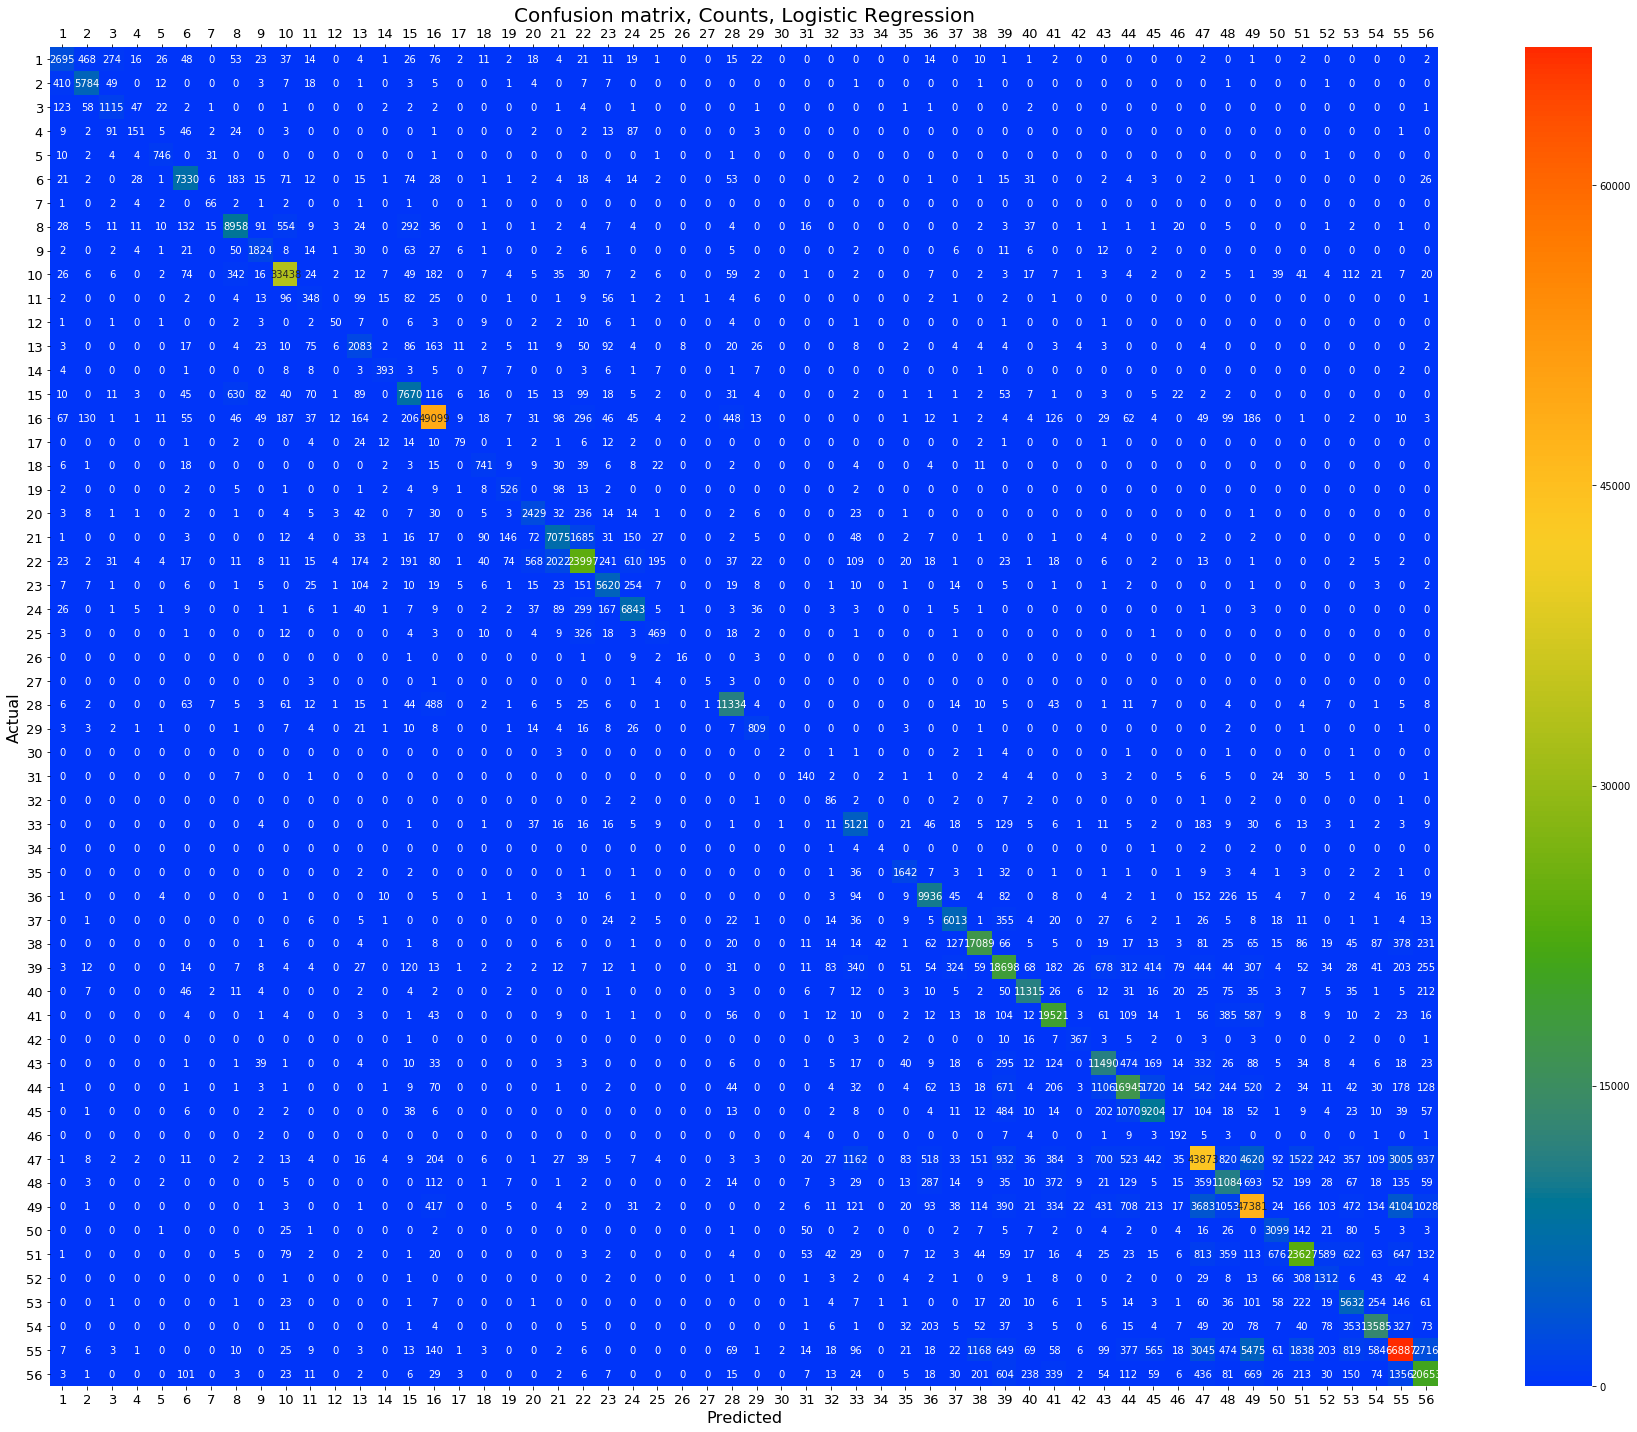

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 11.95s.


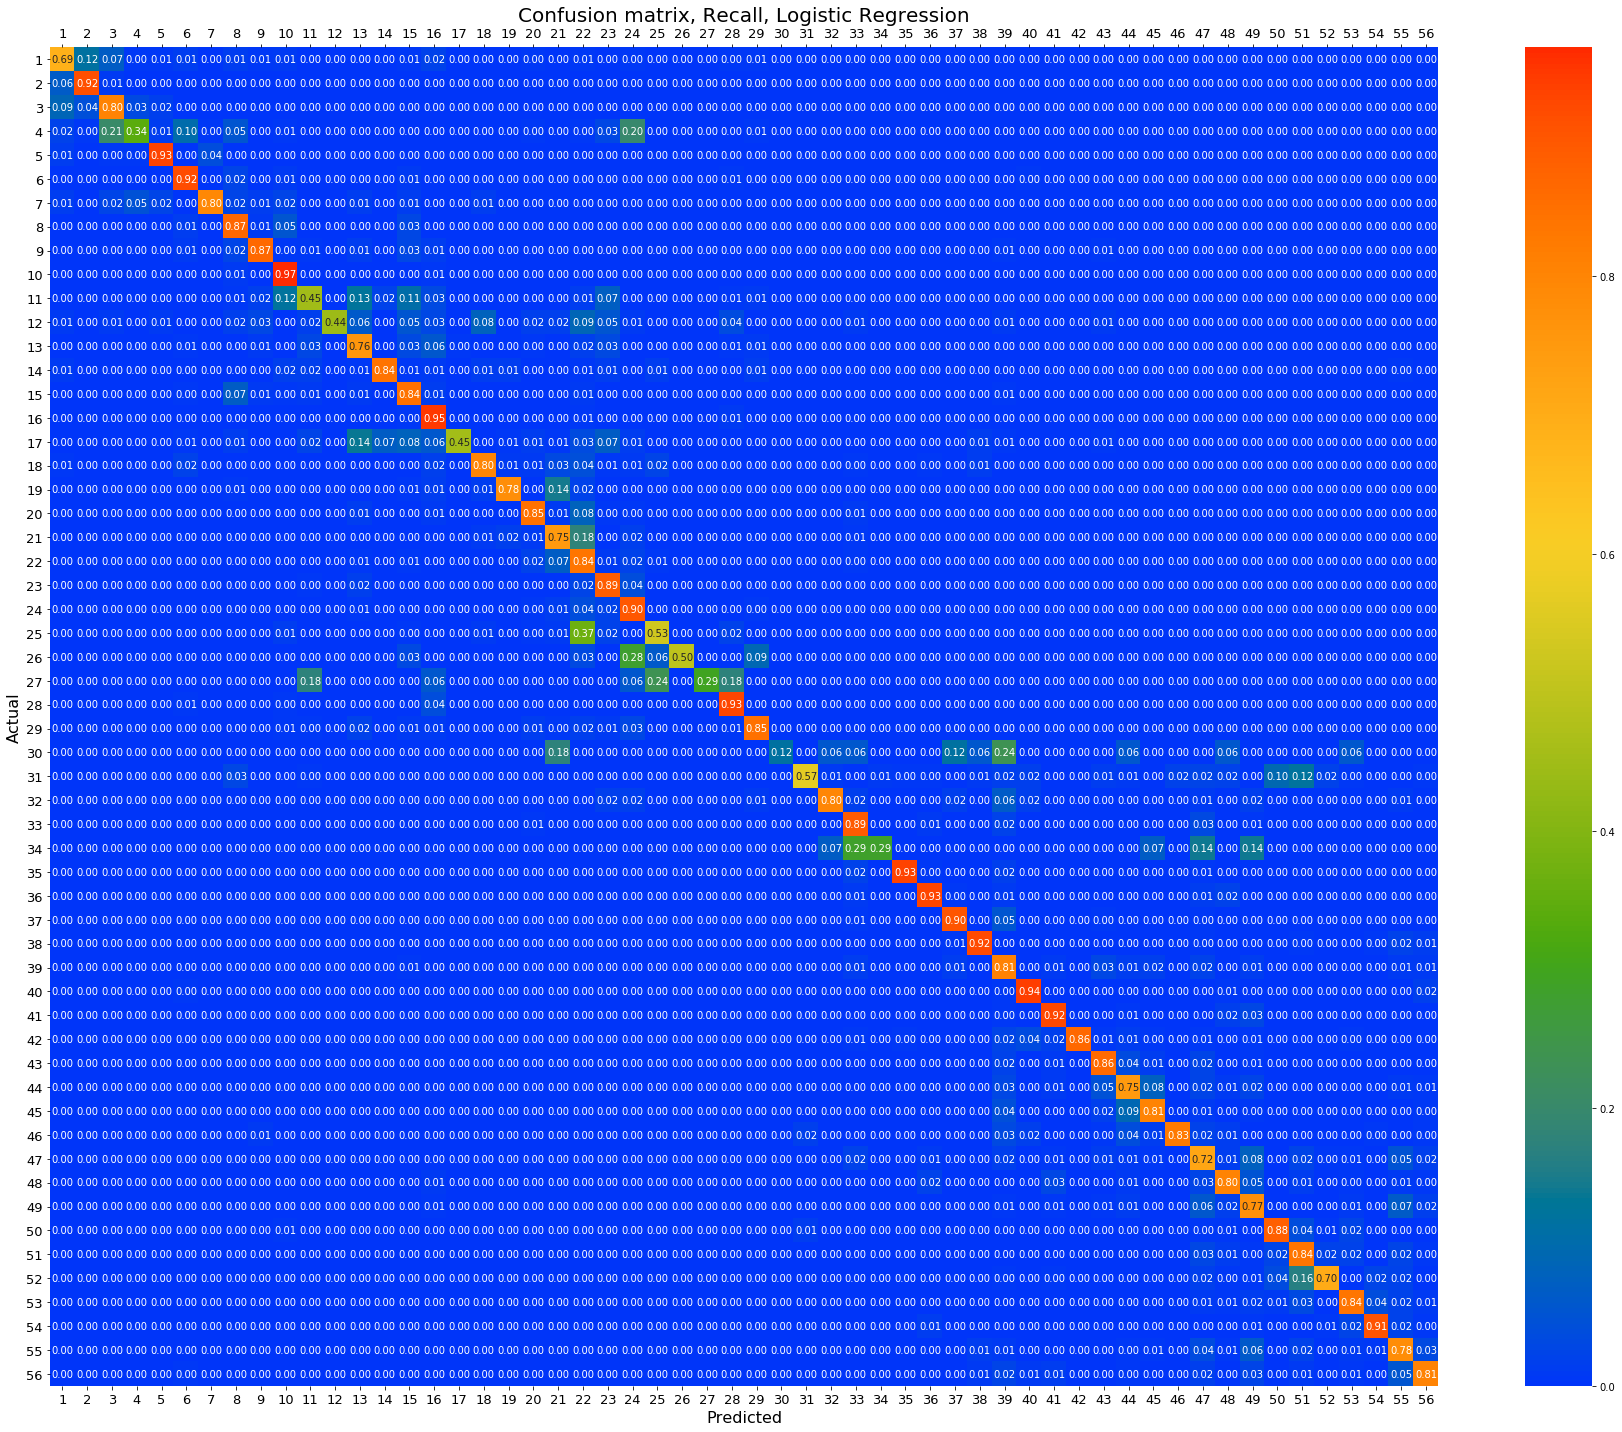

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

Δt: 12.50s.


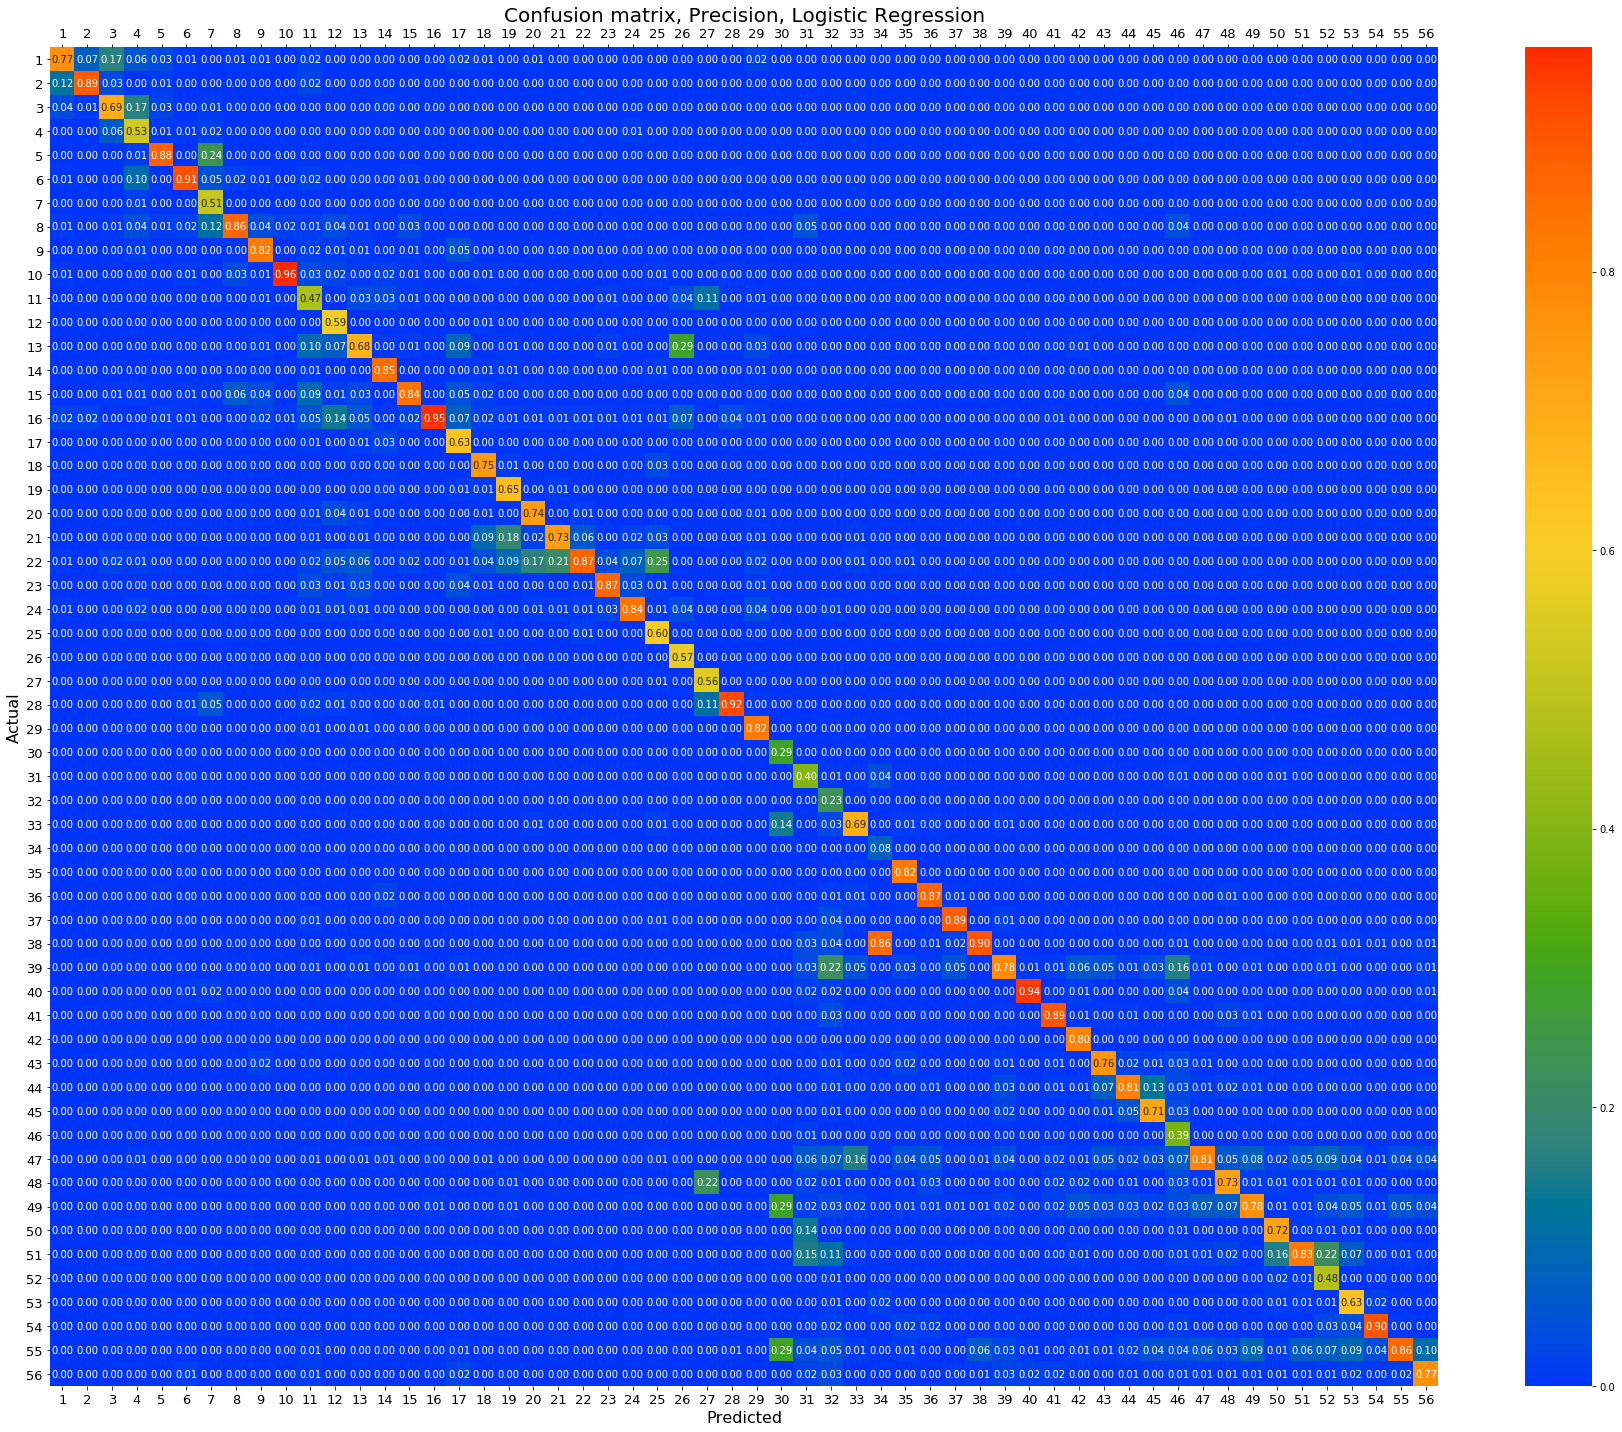

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

In [72]:
del LR

#### Do some garbage collection before building RF models

In [73]:
for i in range(2):
    print('\nCollecting {} ...'.format(i))
    n = gc.collect()
    print('Unreachable objects:', n)
    print('Remaining Garbage:', end=' ')
    pprint.pprint(gc.garbage)


Unreachable objects: 334725
Remaining Garbage: []

Unreachable objects: 0
Remaining Garbage: []


### Random Forest

#### TF-IDF with `FDAISCRITICAL`, `max_depth=250`

* Run defaults for now, except `n_estimators=160` (default is 10)
* For np.shape(Xtr) = (560000, 178558), fit takes ~90 min.

In [74]:
np.shape(Xtrain), np.shape(yTrain), np.shape(Xtest), np.shape(yTest)

((653979, 32873), (653979,), (654005, 32873), (654005,))

In [75]:
print(asctime(gmtime()))
LR1name = 'RandomForest1.joblib'

if os.path.isfile(LR1name):
    LR = load(LR1name)
    t1 = time()
else:
    RF = RandomForestClassifier(random_state=0, n_jobs=7, n_estimators=160,
                                max_depth=250, class_weight='balanced')
    t0 = time()
    RF.fit(Xtrain, yTrain)
    t1 = time()
    Δt01 = t1 - t0
    print("Δt01: {0} m, {1:4.1f} s.".format(int(Δt01//60), Δt01 % 60.0))

yPred = RF.predict(Xtest)
t2 = time()
Δt = t2 - t1
print(f"\n\nΔt: {int(Δt//60)}m, {Δt % 60.0:4.1f}s.")

Tue Aug 20 06:25:08 2019


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=250, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=160, n_jobs=7, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

Δt01: 87 m, 10.7 s.


Δt: 4m, 36.9s.


In [78]:
print(yTest[:20])
print(yPred[:20])

[50 22 51 22 49 16 28 44 51 16 45 55 55 16 48 21 38 33 38 55]
[50 22 51 22 55 16 28 44 51 16 39 55 55 16 48 21 38 33 38 49]


**Save model to disk**

<font color="darkred">Nope. Not agonna do this; model is yuge.</font>

In [ ]:
# if not os.path.isfile(RFname):
#     dump(RF, RFname)

#### Overall accuracy, precision, recall

In [79]:
confusionMat = confusion_matrix(yTest, yPred)
print(confusionMat)

[[ 3040   377   140 ...     0     2     2]
 [  255  5931    33 ...     0     1     0]
 [   70    49  1197 ...     0     1     0]
 ...
 [    0     0     0 ... 14028   260    68]
 [    0     5     0 ...   281 75323  1789]
 [    0     1     0 ...    45  1137 22123]]


In [80]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

accuracy: 0.894, <precision>: 0.814, <recall>: 0.804


##### Recall, precision by class

In [82]:
print(metrics.classification_report(yTest, yPred, target_names=[str(c)for c in FDAcodes]))

              precision    recall  f1-score   support

           1       0.86      0.78      0.81      3922
           2       0.90      0.94      0.92      6315
           3       0.83      0.86      0.84      1387
           4       0.63      0.65      0.64       442
           5       0.90      0.92      0.91       801
           6       0.93      0.92      0.93      7974
           7       0.55      0.83      0.66        83
           8       0.90      0.91      0.90     10293
           9       0.92      0.86      0.89      2107
          10       0.95      0.98      0.96     34644
          11       0.63      0.58      0.60       775
          12       0.65      0.46      0.54       113
          13       0.75      0.78      0.77      2748
          14       0.89      0.88      0.89       467
          15       0.93      0.88      0.90      9078
          16       0.95      0.97      0.96     51679
          17       0.81      0.55      0.66       174
          18       0.81    

In [84]:
classCts = dfTest['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

class	precision	recall	f1	size
55	0.893		0.880	0.887		85601
49	0.869		0.868	0.869		61156
47	0.879		0.840	0.859		60999
16	0.947		0.966	0.956		51679
10	0.947		0.981	0.964		34644
22	0.886		0.921	0.903		28605
51	0.876		0.921	0.898		28115
56	0.842		0.864	0.853		25612
39	0.881		0.866	0.873		23073
44	0.908		0.828	0.866		22667
41	0.933		0.936	0.935		21121
38	0.908		0.933	0.921		18567
54	0.939		0.935	0.937		15008
48	0.895		0.864	0.879		13801
43	0.870		0.904	0.887		13319
28	0.952		0.933	0.942		12213
40	0.943		0.952	0.948		12008
45	0.796		0.888	0.840		11423
36	0.906		0.951	0.928		10676
8	0.897		0.910	0.903		10293
21	0.845		0.842	0.844		9437
15	0.927		0.877	0.901		9078
6	0.933		0.921	0.927		7974
24	0.911		0.873	0.892		7609
53	0.852		0.852	0.852		6714
37	0.905		0.924	0.914		6647
23	0.918		0.923	0.920		6338
2	0.902		0.939	0.920		6315
33	0.914		0.859	0.886		5747
1	0.859		0.775	0.815		3922
50	0.865		0.886	0.875		3510
20	0.903		0.853	0.877		2874
13	0.753		0.780	0.766		2748
9	0.915		0.864	0.889		2107
52

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [85]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

Δt: 13.60s.


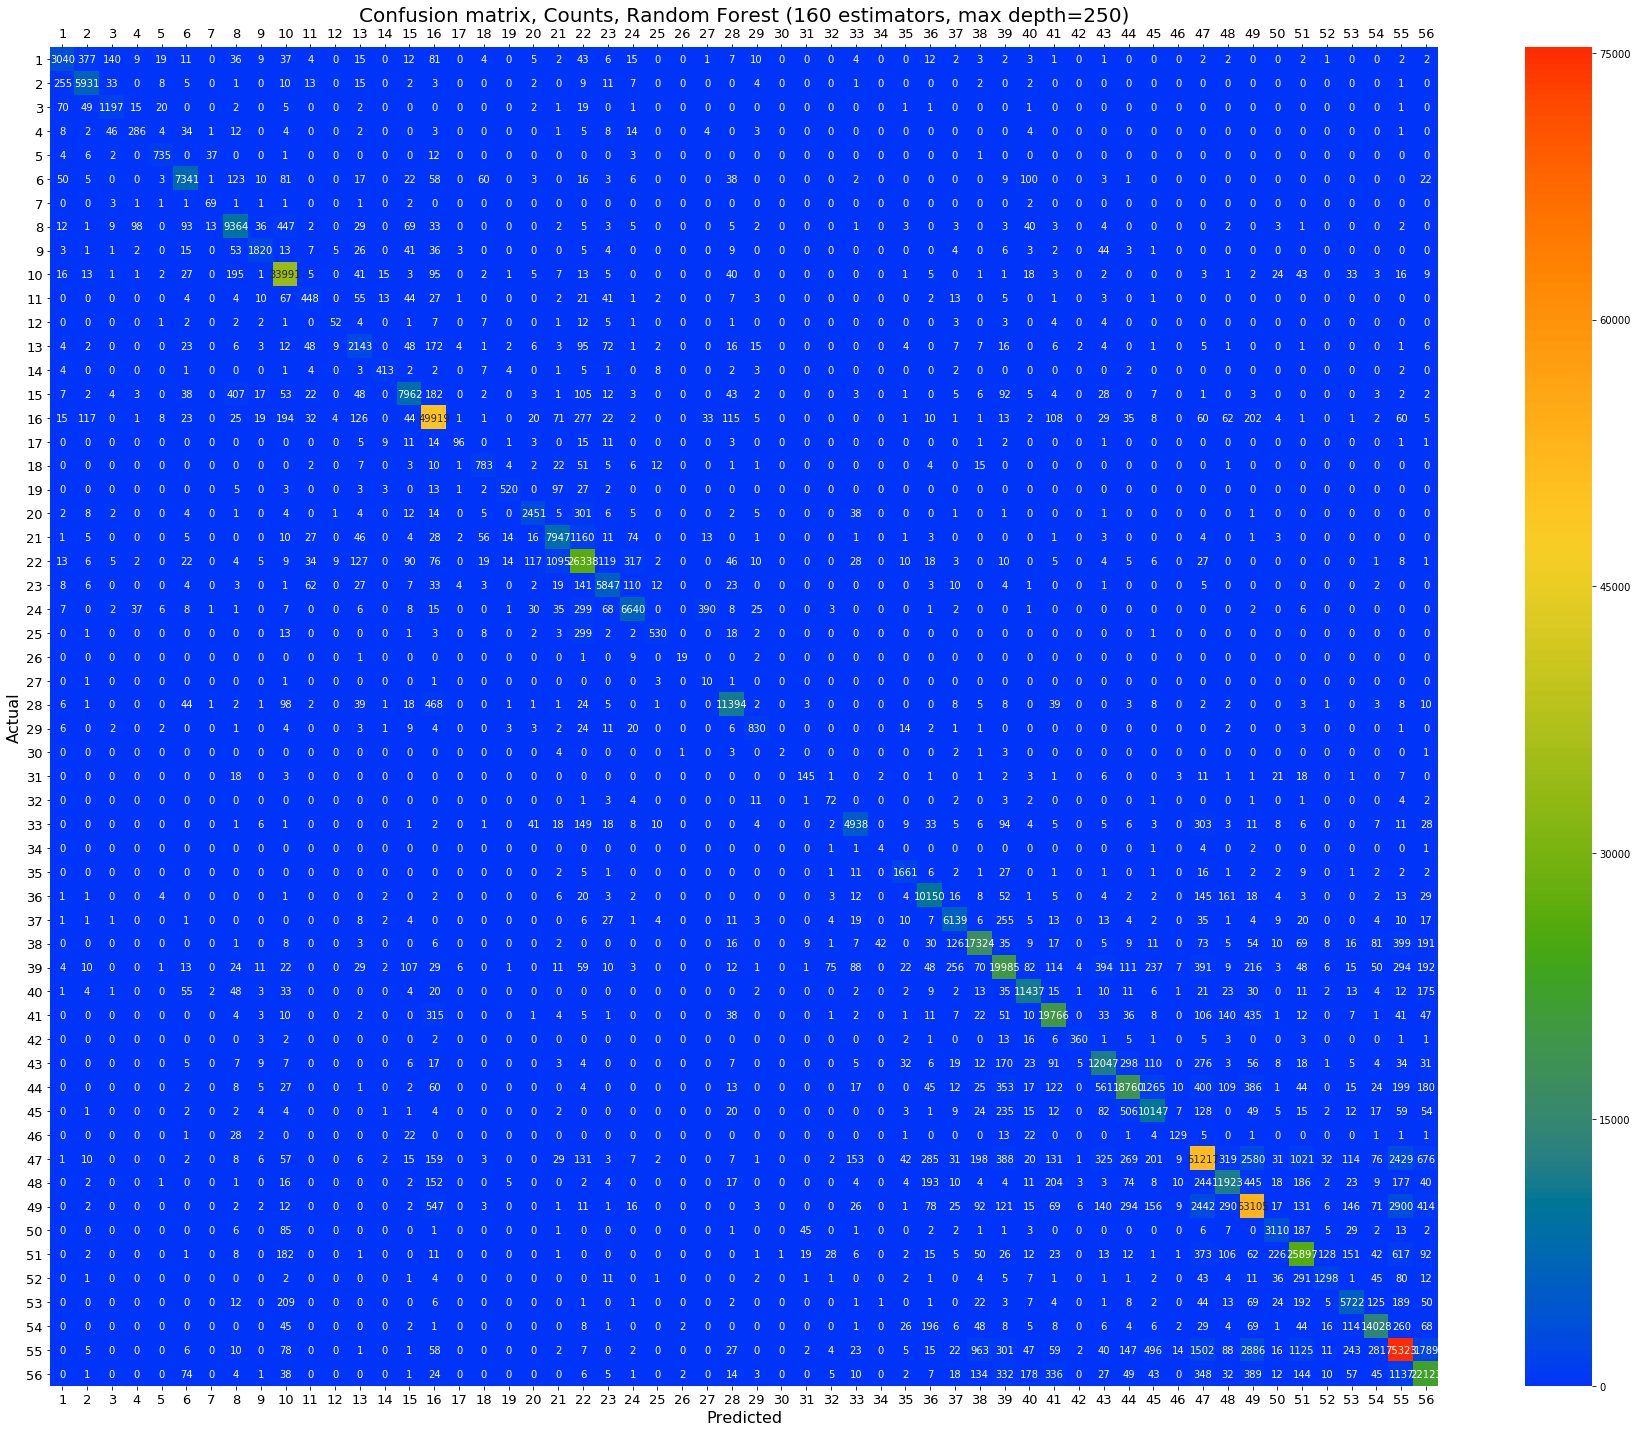

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

Δt: 13.11s.


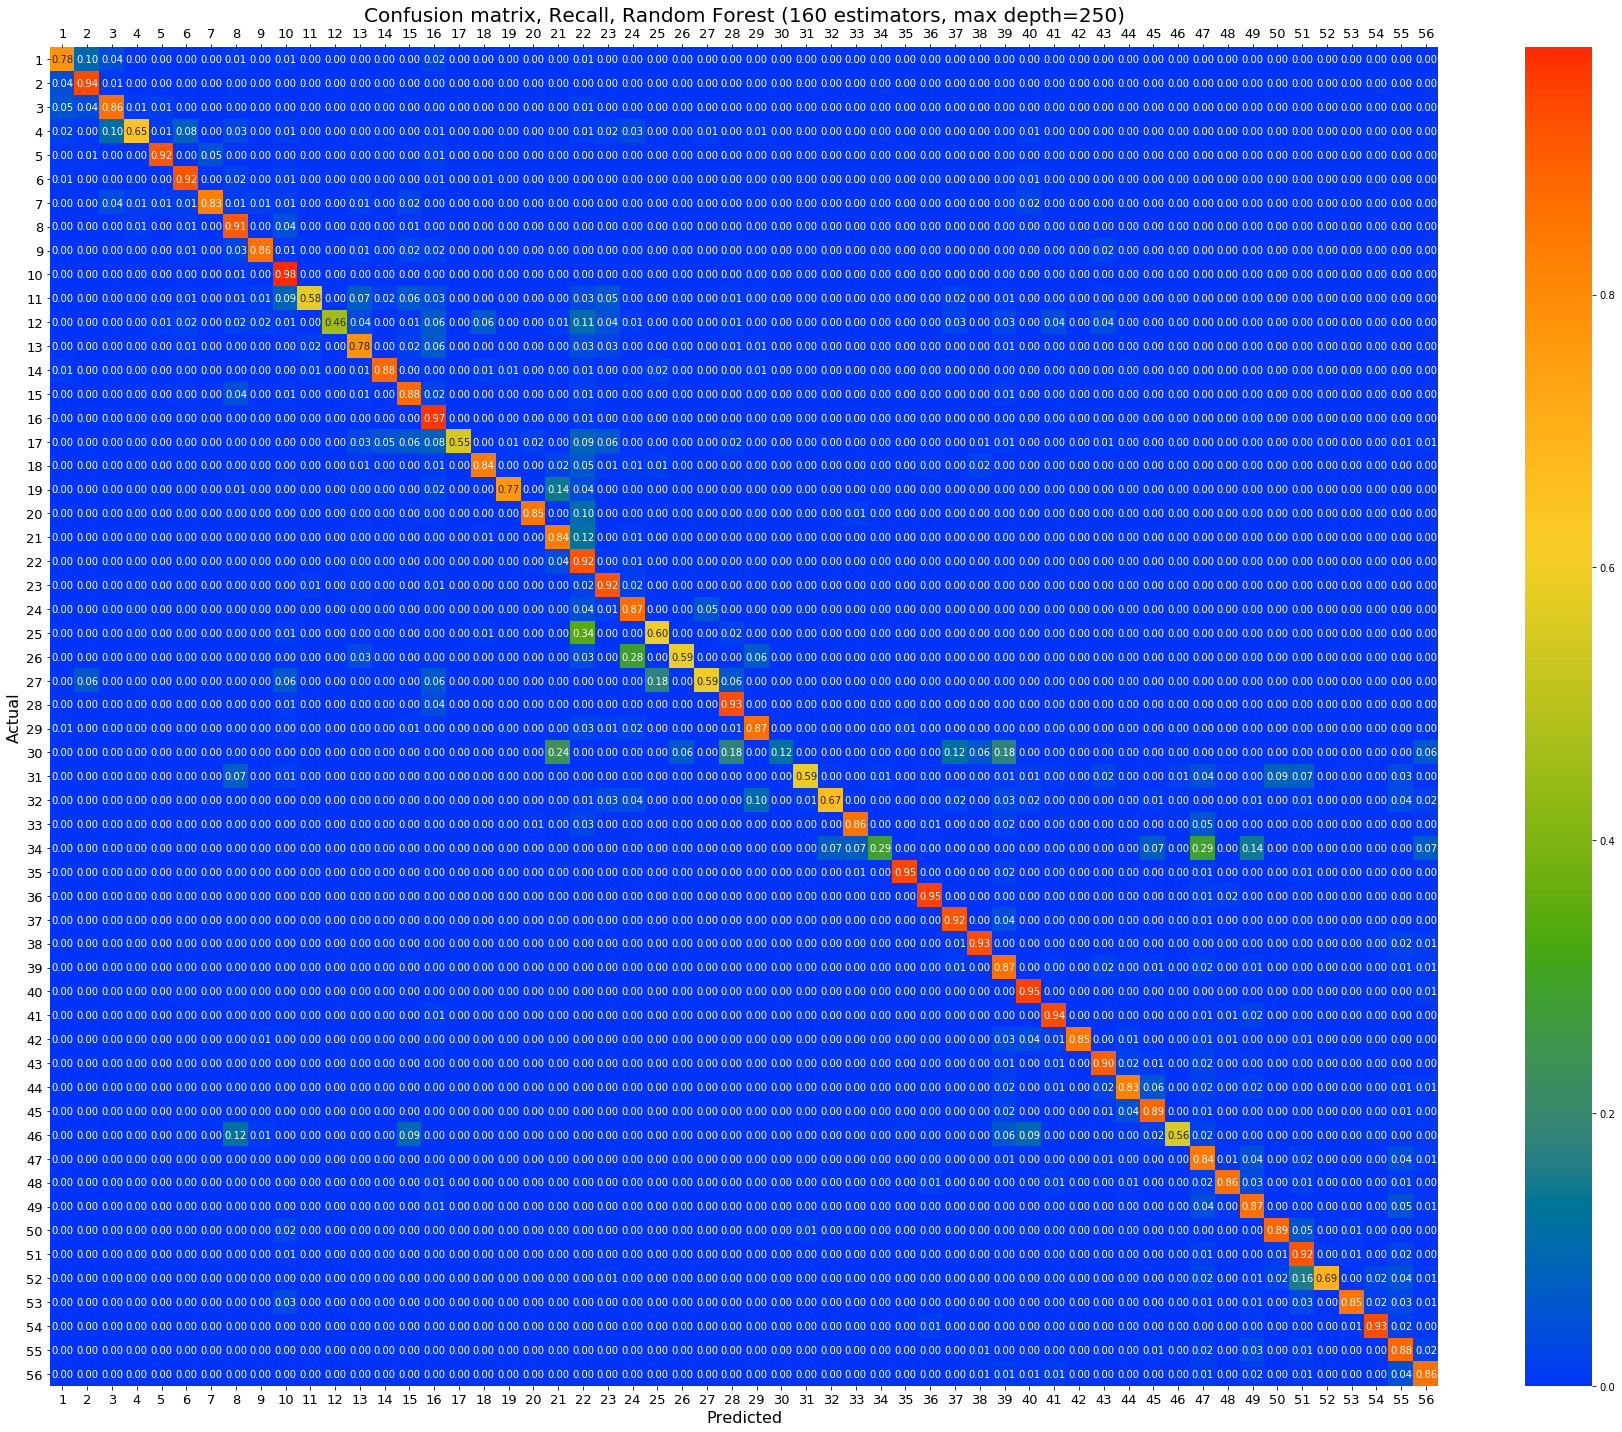

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

Δt: 11.78s.


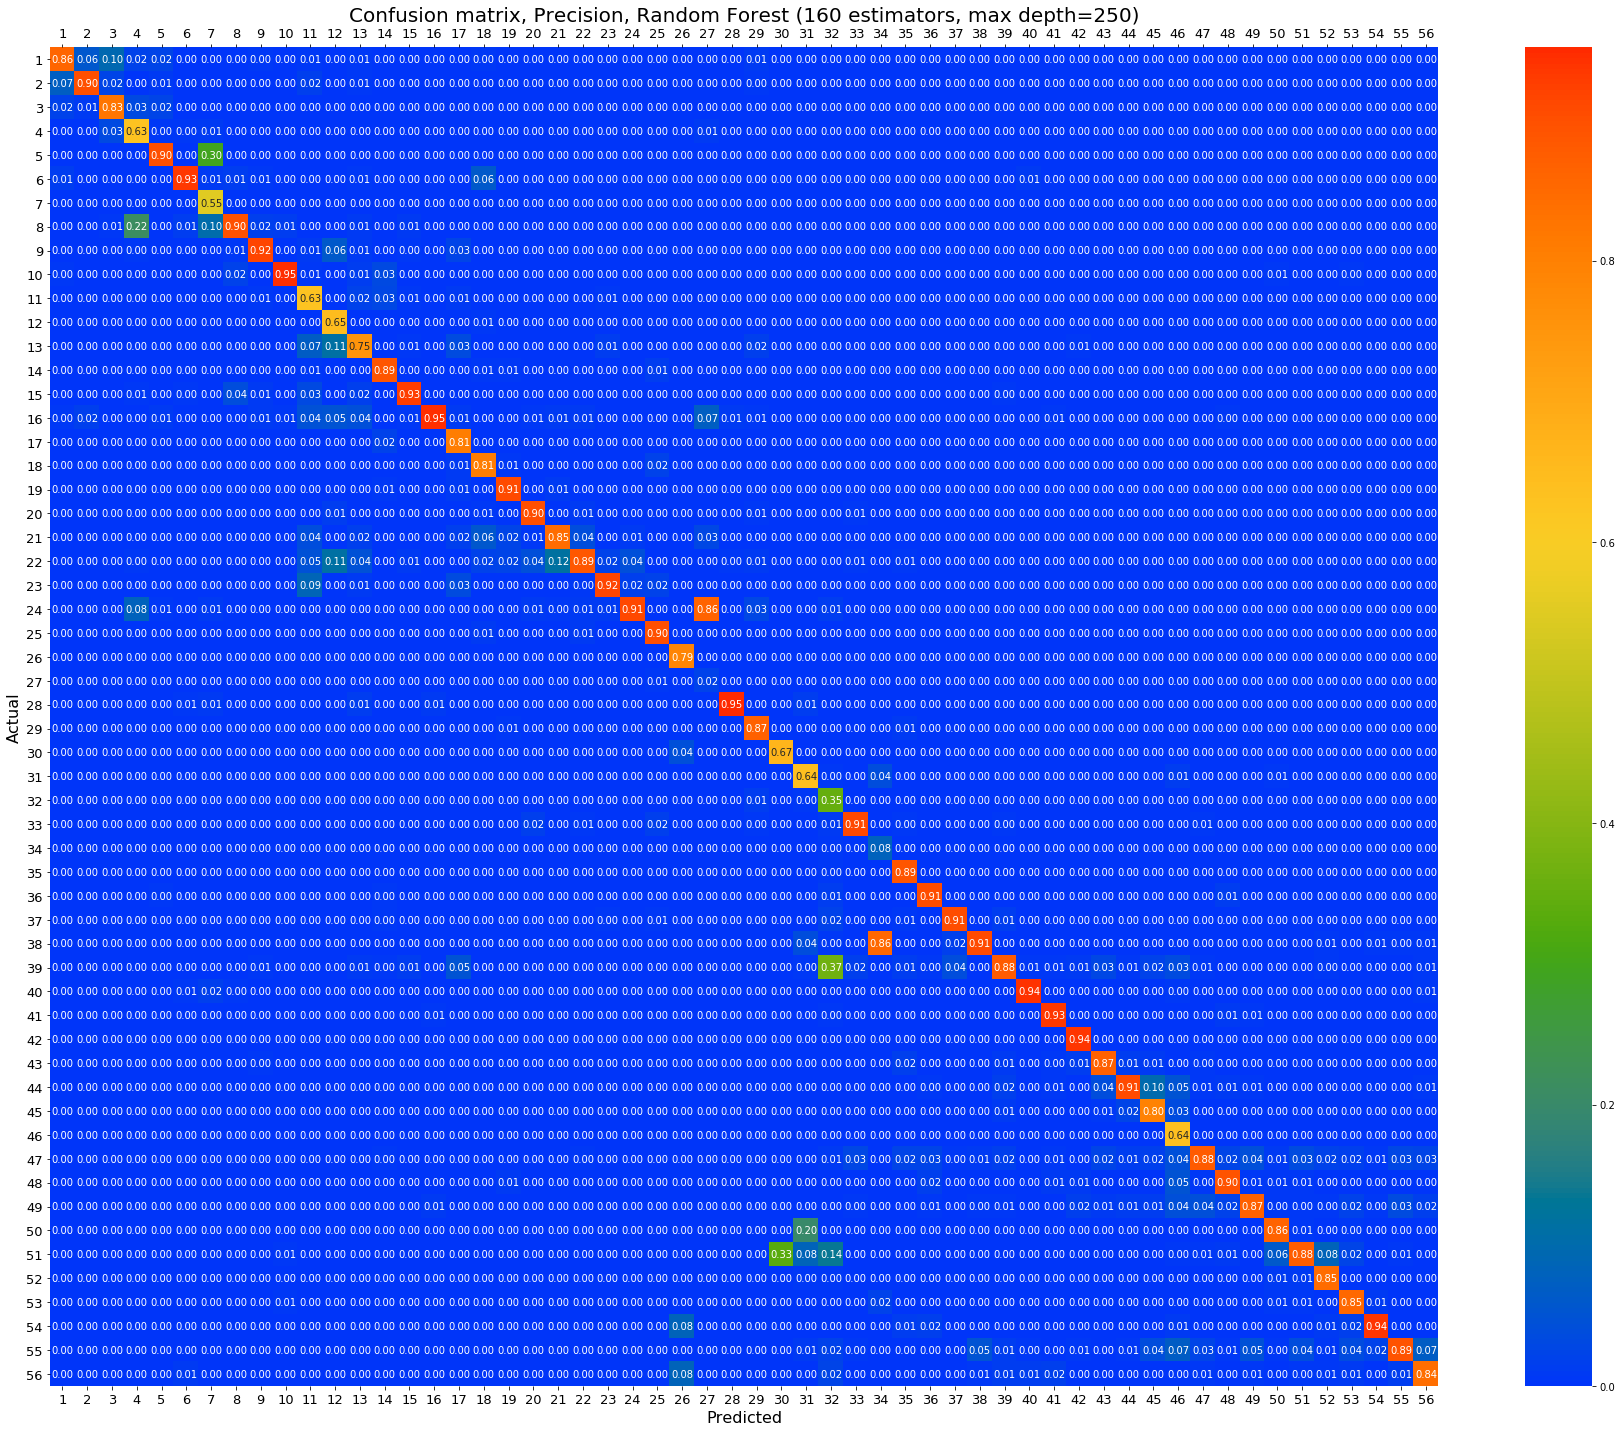

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Random Forest (160 estimators, max depth=250)',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)